# House Prices: Advanced Regression Techniques

In [233]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 200)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [42]:
all_train_set = pd.read_csv('data/train.csv')
all_test_set = pd.read_csv('data/test.csv')

In [159]:
all_train_set.iloc[[1,2,3]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000


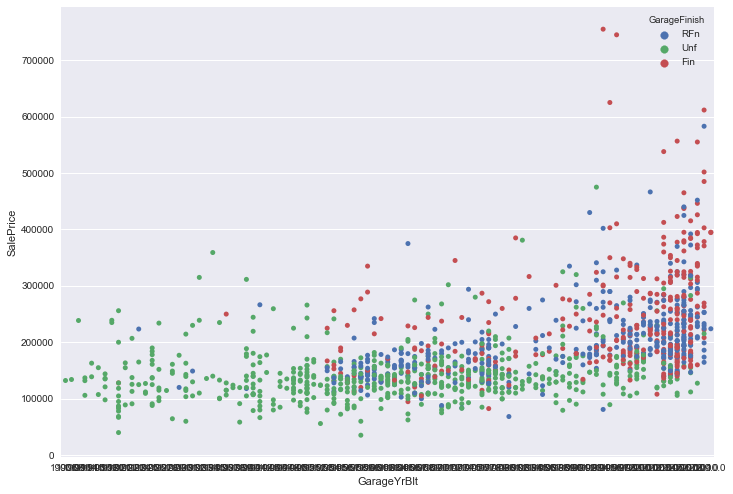

In [307]:
sns.stripplot(x="GarageYrBlt", y="SalePrice", hue='GarageFinish', data=all_train_set);

## Validate a Model

In [146]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction import DictVectorizer

In [325]:
class ColumnSelector(TransformerMixin):
    
    def __init__(self, columns=[]):
        self.columns = columns
        
    def fit(self, X, y, **fit_params):
        return self
        
    def transform(self, X, **transform_params):
        return X[self.columns]
    

class FillNaTransformer(TransformerMixin):
    
    def __init__(self, fill_with):
        self.fill_with = fill_with
        
    def fit(self, X, y, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return X.fillna(self.fill_with)
    

class DebugTransformer(TransformerMixin):
    def fit(self, X, y):
        print("fit")
        print(X)
        print(y)
        return self
        
    def transform(self, X, y=None):
        print("transform")
        print(X)
        print(y) 
        return X
    

class FactorExtractor:
    def __init__(self, factor):
        self.factor = factor

    def transform(self, data):
        return [{self.factor: self.normalize(tt)} for tt in data[self.factor]]

    def fit(self, *_):
        return self
    
    def normalize(self, tag):
        if type(tag) != str: tag = '_MISSING_'
        return tag
    

def factor_feature(name):
    return (name, Pipeline([
        ('extract', FactorExtractor(name)),
        ('label', DictVectorizer(sparse=False))
    ]))

In [327]:
model = Pipeline([
    ('features', FeatureUnion([
        ('continuous', ColumnSelector([
            'LotArea',
            'YearBuilt',
            'YearRemodAdd',
            'BsmtFinSF1',
            'BsmtFinSF2',
            'BsmtUnfSF',
            'TotalBsmtSF',  # may be redundant
            '1stFlrSF',
            '2ndFlrSF',
#             'LowQualFinSF',
#             'GrLivArea',
#             'BsmtFullBath',
            'FullBath',
            'HalfBath',
            'BedroomAbvGr',
            'KitchenAbvGr',
            'TotRmsAbvGrd',
            'Fireplaces',
            'GarageCars',
#             'GarageArea'
        ])),
        ('LotFrontage', Pipeline([
            ('extract', ColumnSelector(['LotFrontage'])),
            ('fill_na', FillNaTransformer(0.0))
        ])),
        ('MasVnrArea', Pipeline([
            ('extract', ColumnSelector(['MasVnrArea'])),
            ('fill_na', FillNaTransformer(0.0))
        ])),
        ('MSSubClass', Pipeline([
            ('extract', ColumnSelector(['MSSubClass'])),
            ('one_hot', OneHotEncoder())
        ])),
        ('GarageYrBlt', Pipeline([
            ('extract', ColumnSelector(['GarageYrBlt'])),
            ('fill_na', FillNaTransformer(0.0))
        ])),
        factor_feature('MSZoning'),
        factor_feature('Street'),
        factor_feature('Alley'),
        factor_feature('LotShape'),
#         factor_feature('LandContour'),
#         factor_feature('Utilities'),
        factor_feature('LotConfig'),
        factor_feature('LandSlope'),
        factor_feature('Neighborhood'),
#         factor_feature('Condition1'),
#         factor_feature('Condition2'),
#         factor_feature('BldgType')
        factor_feature('HouseStyle'),
#         factor_feature('OverallQual'),
#         factor_feature('OverallCond'),
        factor_feature('RoofStyle'),
        factor_feature('RoofMatl'),
        factor_feature('Exterior1st'),
#         factor_feature('Exterior2nd'),
        factor_feature('MasVnrType'),
        factor_feature('ExterQual'),
#         factor_feature('ExterCond'),
#         factor_feature('Foundation'),
        factor_feature('BsmtQual'),
        factor_feature('BsmtCond'),
        factor_feature('BsmtExposure'),
        factor_feature('BsmtFinType1'),
        factor_feature('Heating'),
        factor_feature('HeatingQC'),
        factor_feature('CentralAir'),
#         factor_feature('Electrical'),
        factor_feature('KitchenQual'),
        factor_feature('Functional'),
#         factor_feature('FireplaceQu'),
#         factor_feature('GarageType'),
#         factor_feature('GarageFinish'),
        factor_feature('GarageQual')
    ])),
    ('regressor', Lasso(max_iter=30000))
])

kfold = KFold(5)
np.random.seed(0)
rmses = []

for (train_idx, cv_idx) in kfold.split(all_train_set):
    construct = all_train_set.iloc[train_idx]
    validate = all_train_set.iloc[cv_idx]
    
    construct_X = construct
    construct_y = construct['SalePrice']
    
    validate_X = validate
    validate_y = validate['SalePrice']
    
    model.fit(construct_X, y=construct_y)
    predictions = model.predict(validate_X)
    rmse = np.sqrt(mean_squared_error(validate_y, predictions))
    rmses.append(rmse)
    print(rmse)
    
np.mean(rmses)

23162.859882036642
35859.38155057963
28461.682364511307
23020.081705037494
44524.82903503391


31005.766907439793

```
23162.859882036642
35859.38155057963
28461.682364511307
23020.081705037494
44524.82903503391
31005.766907439793
```

## Make a Submission

In [328]:
model.fit(all_train_set, y=all_train_set['SalePrice'])

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', <__main__.ColumnSelector object at 0x11453e6a0>), ('LotFrontage', Pipeline(memory=None,
     steps=[('extract', <__main__.ColumnSelector object at 0x11453ebe0>), ('fill_na', <__main__.FillNaTransformer object at 0x114...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [329]:
predictions = model.predict(all_test_set)

In [330]:
predictions

array([108386.21411627, 151137.16043852, 189899.59883634, ...,
       166139.04476097, 115520.74325084, 216590.21911507])

In [331]:
submission = pd.DataFrame({'Id': all_test_set['Id'], 'SalePrice': predictions})

In [333]:
submission.to_csv('submission.csv', index=False)

In [338]:
np.isnan(s)

array([108386.21411627, 151137.16043852, 189899.59883634, ...,
       166139.04476097, 115520.74325084, 216590.21911507])